In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
#allocs = pd.Series([.3, .3, .35, .05, 1], index=['ES','NQ', 'GC', 'CL', 'total'])
allocs = pd.Series([.5, .5, 1], index=['ES','NQ', 'total'])
cash = 100000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-03-10_15-27_20190101_20191231.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])

In [4]:
df.groupby('contract').realizedPNL.sum()

contract
ES    23124.3
NQ     5409.6
Name: realizedPNL, dtype: float64

In [5]:
df.realizedPNL.sum()

28533.899999999998

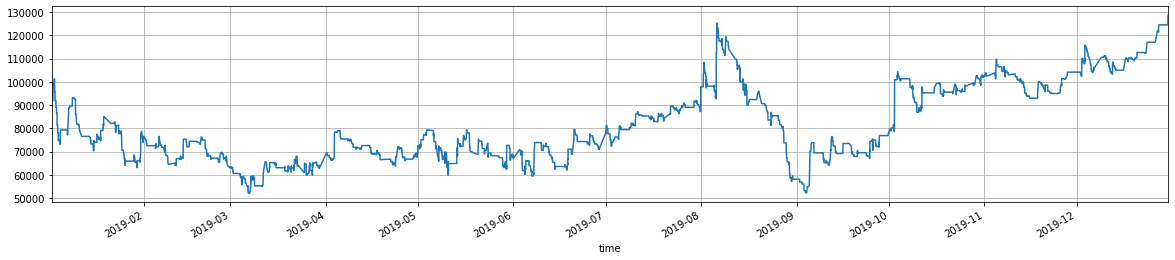

In [6]:
df.cash.plot(figsize=(20,4), grid=True);

In [7]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [8]:
# number of trades
trades = df.groupby('contract').action.count()
trades

contract
ES     426
NQ    2076
Name: action, dtype: int64

In [9]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     4288.2
NQ    18950.4
Name: commission, dtype: float64

In [10]:
df.commission.sum()

23238.600000000002

In [11]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.37,5.21,1353.14,-796.09,1.70,-0.87,1038.0
ES,0.37,108.56,3613.19,-1916.33,1.89,129.59,213.0
total,0.37,22.81,1732.25,-988.50,1.75,18.18,1251.0


In [12]:
by_contract.resample('B').sum()

contract,ES,NQ,total
time,,,
2019-01-02,-12229.5,8012.0,-4217.5
2019-01-03,0.0,-17661.6,-17661.6
2019-01-04,0.0,1200.8,1200.8
2019-01-07,11749.8,-1442.0,10307.8
2019-01-08,2354.0,1233.0,3587.0
...,...,...,...
2019-12-24,0.0,0.0,0.0
2019-12-25,0.0,0.0,0.0
2019-12-26,0.0,2212.8,2212.8


In [13]:
by_contract.resample('B').sum() / (allocs * cash)

contract,ES,NQ,total
time,,,
2019-01-02,-0.244590,0.160240,-0.042175
2019-01-03,0.000000,-0.353232,-0.176616
2019-01-04,0.000000,0.024016,0.012008
2019-01-07,0.234996,-0.028840,0.103078
2019-01-08,0.047080,0.024660,0.035870
...,...,...,...
2019-12-24,0.000000,0.000000,0.000000
2019-12-25,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.044256,0.022128


In [32]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [34]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

contract,ES,NQ,total
contract,,,
ES,1.000000,0.049402,0.768331
NQ,0.049402,1.000000,0.674165
total,0.768331,0.674165,1.000000


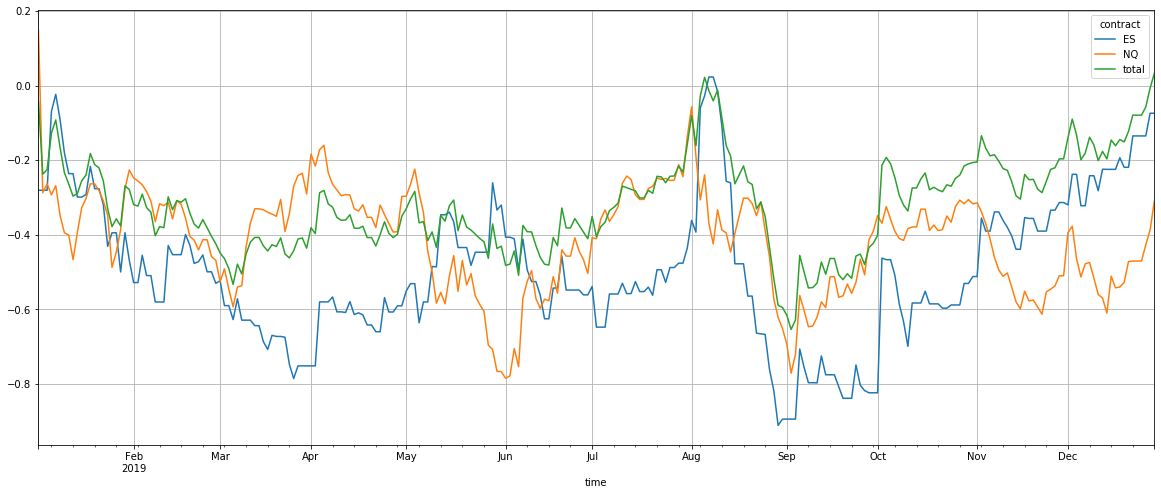

In [36]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

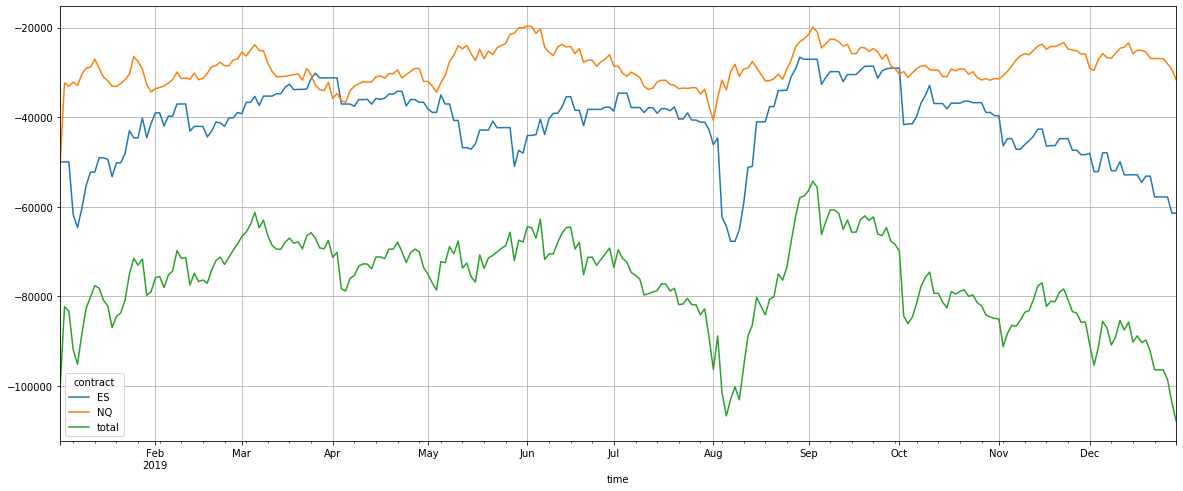

In [25]:
returns = daily
returns.iloc[0] = (daily.iloc[0] * (allocs * cash))-1
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [37]:
daily

contract,ES,NQ,total
time,,,
2019-01-02,-0.244590,0.160240,-0.042175
2019-01-03,0.000000,-0.353232,-0.176616
2019-01-04,0.000000,0.024016,0.012008
2019-01-07,0.234996,-0.028840,0.103078
2019-01-08,0.047080,0.024660,0.035870
...,...,...,...
2019-12-24,0.000000,0.000000,0.000000
2019-12-25,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.044256,0.022128


In [38]:
returns=daily

In [39]:
returns

contract,ES,NQ,total
time,,,
2019-01-02,-0.244590,0.160240,-0.042175
2019-01-03,0.000000,-0.353232,-0.176616
2019-01-04,0.000000,0.024016,0.012008
2019-01-07,0.234996,-0.028840,0.103078
2019-01-08,0.047080,0.024660,0.035870
...,...,...,...
2019-12-24,0.000000,0.000000,0.000000
2019-12-25,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.044256,0.022128


In [40]:
stats = pd.DataFrame()
for col in returns.columns:
    stats[col] = perf_stats(returns[col])
stats

,ES,NQ,total
Annual return,-0.069619,-0.258708,0.033089
Cumulative returns,-0.071482,-0.264847,0.034024
Annual volatility,1.060826,0.885351,0.708584
Sharpe ratio,0.424185,0.118900,0.391806
Calmar ratio,-0.114713,-0.426494,0.067377
Stability,0.006927,0.102432,0.107127
Max drawdown,-0.606899,-0.606594,-0.491107
Omega ratio,1.102290,1.021069,1.070776
Sortino ratio,0.760638,0.169195,0.629562
Skew,2.088677,-0.520659,0.824253


In [21]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

contract,ES,NQ,total
time,,,
2019-01-31,-37.36,-20.24,-24.31
2019-02-28,-6.03,-21.49,-13.55
2019-03-31,-19.84,19.43,-1.16
2019-04-30,17.46,-0.65,8.92
2019-05-31,30.99,-37.46,-7.70
2019-06-30,-21.39,30.08,2.01
2019-07-31,13.39,44.22,28.79
2019-08-31,-36.78,-40.15,-35.41
2019-09-30,7.31,29.72,18.76


In [22]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

contract
ES       -7.0
NQ      -26.0
total     3.0
dtype: float64

In [23]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 20:20:00,ES,BUY,2887.25,21729.0
2019-08-05 21:18:00,ES,BUY,2837.75,19729.0
2019-01-07 12:20:00,ES,SELL,2523.25,11749.8
2019-05-29 19:08:00,ES,BUY,2780.75,10229.0
2019-09-05 09:09:00,ES,SELL,2954.00,9666.5
...,...,...,...,...
2019-08-27 21:05:00,ES,BUY,2882.00,-4458.5
2019-08-12 01:34:00,ES,SELL,2914.25,-4458.5
2019-08-15 21:00:00,ES,BUY,2849.00,-4646.0
